# Data setup and cleaning

In [21]:
import pandas as pd
import numpy as np

In [4]:
# HELPER FUNCTIONS - DATA CLEANING

import re
HMTL_TAG = re.compile('<.*?>') 
WHITESPACE = re.compile(r'\s+')

def replace_html_tags(raw_html, replace_with = ''):
  clean_text = re.sub(HMTL_TAG, replace_with, str(raw_html))
  return clean_text

def replace_whitespace(raw_text, replace_with = ' '):
  clean_text = re.sub(WHITESPACE, replace_with, str(raw_text))
  return clean_text

def clean_text(raw_text):
  clean_text = replace_html_tags(raw_text)
  clean_text = replace_whitespace(clean_text)
  return clean_text

# Clean text for every row in a pandas dataframe column. Returns new dataframe with cleaned text.
def clean_text_batch(df: pd.DataFrame, col: int) -> pd.DataFrame:
  df.iloc[:, col] = df.iloc[:, col].apply(lambda x: clean_text(x))
  return df

In [54]:
# HELPER FUNCTIONS - DATA ANALYSIS / INTERPRETATION

LISTING_FIELDS = ['id','listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview','picture_url','host_id','host_url','host_name','host_since','host_location','host_about','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic','host_identity_verified','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','latitude','longitude','property_type','room_type','accommodates','bathrooms','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','has_availability','availability_30','availability_60','availability_90','availability_365','calendar_last_scraped','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','first_review','last_review','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','license','instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month']
REVIEW_FIELDS = ['listing_id','id','date','reviewer_id','reviewer_name','comments']

# function to quickly return index of a given string in LISTING_FIELDS
def index_in_listings(field: str) -> int:
    return LISTING_FIELDS.index(field)

# function to quickly return index of a given string in REVIEW_FIELDS
def index_in_reviews(field: str) -> int:
    return REVIEW_FIELDS.index(field)

# function to map a string reading 't' or 'f' to a boolean
def as_bool(t_f: str) -> bool:
    if t_f == 't':
        return True
    elif t_f == 'f':
        return False
    else:
        raise ValueError('Invalid value for boolean: ' + t_f)

# function to normalise a numpy array to floats between 0 and 1
def normalise(arr: np.ndarray) -> np.ndarray:
    return arr / arr.sum()



In [6]:
# CLEAN LISTINGS TEXT AND SAVE TO NEW CSV
df_listings = pd.read_csv("../data/listings.csv")

# print(df_listings.applymap(lambda x: isinstance(x, str)).all(0))

# Names and indices of columns to clean
COLS_TO_CLEAN = {
    'description': 6,
    'neighborhood_overview': 7,
    'host_about': 14
}

for col in COLS_TO_CLEAN:
    df_listings = clean_text_batch(df_listings, COLS_TO_CLEAN[col])

# df_listings.to_csv('../data/listings_clean.csv', index=False)

In [52]:
# SELECT ONLY TARGET COLUMNS FROM LISTINGS -> SAVE TO NEW CSV

df_listings = pd.read_csv("../data/listings.csv")

# col names: review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
LISTING_COLS_TO_RETAIN = {
    'id': index_in_listings('id'),
    'review_scores_rating': index_in_listings('review_scores_rating'),
    'review_scores_accuracy': index_in_listings('review_scores_accuracy'),
    'review_scores_cleanliness': index_in_listings('review_scores_cleanliness'),
    'review_scores_checkin': index_in_listings('review_scores_checkin'),
    'review_scores_communication': index_in_listings('review_scores_communication'),
    'review_scores_location': index_in_listings('review_scores_location'),
    'review_scores_value': index_in_listings('review_scores_value')
}

df_listings = df_listings.iloc[:, list(LISTING_COLS_TO_RETAIN.values())]
df_listings = df_listings.dropna()
df_listings = df_listings.sort_values(by=['id'])
df_listings.to_csv('../data/listings_targets.csv', index=False)

# NOTE: Some listings do not have some or all of the review scores. We will need to account for this when we train our model.

# print(df_listings.applymap(lambda x: isinstance(x, str)).all(0))


In [56]:
# CLEAN REVIEWS TEXT AND SELECT ONLY KEY COLUMNS -> SAVE TO NEW CSV

df_reviews = pd.read_csv("../data/reviews.csv")
df_reviews = clean_text_batch(df_reviews, 5)

REVIEW_COLS_TO_RETAIN = {
    'listing_id': index_in_reviews('listing_id'),
    'comments': index_in_reviews('comments')
}

df_reviews = df_reviews.iloc[:, list(REVIEW_COLS_TO_RETAIN.values())]

# Sort by listing_id, so reviews for a given listing are grouped together
df_reviews = df_reviews.sort_values(by=['listing_id'])
df_reviews.to_csv('../data/reviews_skeleton.csv', index=False)


In [24]:
comments = df_reviews.iloc[:, 5].values
print(comments.shape)
print(comments[0])

(243183,)
We enjoyed our stay very much. The room was comfortable, neat and clean. There were no problems at all and the host family was very helpful and caring. They helped us planning trips or recommended sights. The house is situated in a calm neighbourhood close the the Luas and different bus lines. There are no negative aspects to mention, it was a very satisfying stay. I would recommend it and stay there again whenever I am in Dublin. 


# Text Feature Extraction


In [47]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer

# df_max - exclude words which appear in too many documents
# df_min - exclude words which appear in too few documents
# Use cross validation to determine best values for these parameters.
# HAVE TO USE MIN_DF, otherwise feature vectors are:
# a) too large for my computer to handle.
# b) too full of zeros to be useful.
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.2, min_df=0.001) # 93,193 features

# A single doc will be a list of sentences, in this case a single review.
# Each sentence will be a list of words, or in this case tokens, which have been stemmed.
vectors = vectorizer.fit_transform(comments)
print(len(vectorizer.get_feature_names_out()))
print(vectors.shape)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2214
(243183, 2214)
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


In [48]:
print(vectors[0])

  (0, 1611)	0.10034119226853999
  (0, 1252)	0.2606826520004324
  (0, 1326)	0.2716879035414134
  (0, 1148)	0.2735265929660197
  (0, 292)	0.12506550921867488
  (0, 569)	0.2325298183156135
  (0, 1197)	0.19759874300173133
  (0, 399)	0.11856310154980176
  (0, 1329)	0.2040305194885017
  (0, 310)	0.2364094149157616
  (0, 1779)	0.2093844068652601
  (0, 986)	0.11722260700044745
  (0, 1762)	0.21706501481789367
  (0, 1615)	0.16504067658028237
  (0, 2031)	0.2510637012729492
  (0, 1490)	0.2518556702440787
  (0, 946)	0.1919402492295867
  (0, 322)	0.24929458730293394
  (0, 947)	0.11926036963913877
  (0, 757)	0.1610923727814727
  (0, 1539)	0.23053478573094208
  (0, 1318)	0.23720957484615215
  (0, 416)	0.10996789961582039
  (0, 1675)	0.10958327466086534
  (0, 681)	0.14809332862871688


We are trying to predict the ratings of a listing based on reviews for that listing.

So in order to train the model, we need to group all reviews for a particular listing with the appropriate listing id.

# Features and Targets

In [57]:
df_listings = pd.read_csv("../data/listings.csv")

# col names: review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
LISTING_COLS_TO_RETAIN = {
    'id': index_in_listings('id'),
    'review_scores_rating': index_in_listings('review_scores_rating'),
    'review_scores_accuracy': index_in_listings('review_scores_accuracy'),
    'review_scores_cleanliness': index_in_listings('review_scores_cleanliness'),
    'review_scores_checkin': index_in_listings('review_scores_checkin'),
    'review_scores_communication': index_in_listings('review_scores_communication'),
    'review_scores_location': index_in_listings('review_scores_location'),
    'review_scores_value': index_in_listings('review_scores_value')
}

targets = df_listings.iloc[:, list(LISTING_COLS_TO_RETAIN.values())]
targets = targets.dropna()
targets = targets.sort_values(by=['id'])

targ_ratings = targets.iloc[:, 1].values
targ_acc = targets.iloc[:, 2].values
targ_clean = targets.iloc[:, 3].values
targ_checkin = targets.iloc[:, 4].values
targ_comm = targets.iloc[:, 5].values
targ_loc = targets.iloc[:, 6].values
targ_value = targets.iloc[:, 7].values

# Save targets to csv
# targets.to_csv('../data/listings_targets_comp.csv', index=False)

In [58]:
print(targets.shape)

(6078, 8)


In [67]:
# Group review comments by listing_id
reviews = pd.read_csv("../data/reviews_skeleton.csv")
reviews = reviews.dropna()
reviews = reviews.sort_values(by=['listing_id'])
reviews_by_listing = reviews.groupby('listing_id').agg({'comments': '. '.join})
reviews_by_listing = reviews_by_listing.reset_index()
reviews_by_listing.to_csv('../data/reviews_by_listing.csv', index=False)

# Tokenise and stem reviews
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

# Function to map each string of comments to stems
def stem_review(review):
    tokens = word_tokenize(review)
    stems = [stemmer.stem(token) for token in tokens]
    return ' '.join(stems)

reviews_by_listing['stems'] = reviews_by_listing['comments'].apply(stem_review)

stems_by_listing = reviews_by_listing[['listing_id', 'stems']]

# for index, row in reviews_by_listing.iterrows():
#     listing_id = row['listing_id']
#     comments = row['comments']
#     tokens = word_tokenize(comments)
#     stems = [stemmer.stem(token) for token in tokens]
#     ' '.join(stems)
#     stems_by_listing.append([listing_id, stems])

# stems_by_listing = pd.DataFrame(stems_by_listing, columns=['listing_id', 'stems'])

# Save stems to csv
stems_by_listing.to_csv('../data/stems_by_listing.csv', index=False)



In [68]:
# SELECT ONLY LISTINGS WITH BOTH REVIEWS AND TARGETS
reviews = pd.read_csv("../data/stems_by_listing.csv")
targets = pd.read_csv("../data/listings_targets_comp.csv")

# Sort both by listing_id
reviews = reviews.sort_values(by=['listing_id'])
targets = targets.sort_values(by=['id'])

# Drop rows where listing_id is not included in both
reviews = reviews[reviews['listing_id'].isin(targets['id'])]
targets = targets[targets['id'].isin(reviews['listing_id'])]


In [69]:
# Should have same number of rows (but different number of columns)
print(reviews.shape)
print(targets.shape)

(6078, 2)
(6078, 8)


In [71]:
stemmed_comments = reviews['stems'].values

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer

# df_max - exclude words which appear in too many documents
# df_min - exclude words which appear in too few documents
# Use cross validation to determine best values for these parameters.
# HAVE TO USE MIN_DF, otherwise feature vectors are:
# a) too large for my computer to handle.
# b) too full of zeros to be useful.
# vectorizer = TfidfVectorizer(stop_words='english', max_df=0.2, min_df=0.001) # 93,193 features
vectorizer = TfidfVectorizer(stop_words='english') # 79,179 features for 6,078 listings

# A single doc will be a list of sentences, in this case a single review.
# Each sentence will be a list of words, or in this case tokens, which have been stemmed.
X = vectorizer.fit_transform(stemmed_comments)
print(len(vectorizer.get_feature_names_out()))
print(X.shape)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


79179
(6078, 79179)


In [85]:
# CHECKING IF WE NEED TO NORMALISE
# (We don't. Max value is 1.0, min is 0.0)

arr = X.toarray()

# Print maximum value
print(np.amin(arr)) # Hoping this is 0.0
print(np.amax(arr)) # Hoping this is 1.0

# Just curious about the distribution of values
# Print mean, median, and standard deviation of values
# print(np.mean(arr))
# print(np.median(arr))
# print(np.std(arr))
# Values are mostly very low


0.0
1.0


In [91]:
Y = targets.iloc[:, 1:].values
print(Y.shape)

# Split into different categories
Y_rating = Y[:, 0]
Y_acc = Y[:, 1]
Y_clean = Y[:, 2]
Y_checkin = Y[:, 3]
Y_comm = Y[:, 4]
Y_loc = Y[:, 5]
Y_value = Y[:, 6]


(6078, 7)


In [89]:
print(X.shape)
print(X.shape[0])

(6078, 79179)
6078


Other features

In [116]:
listings = pd.read_csv("../data/listings_clean.csv")

# Pull out interesting features
FEATURES_OF_INTEREST = {
    'id': index_in_listings('id'),
    'host_is_superhost': index_in_listings('host_is_superhost'),
    'host_total_listings_count': index_in_listings('host_total_listings_count'),
    'accommodates': index_in_listings('accommodates'),
    'number_of_reviews': index_in_listings('number_of_reviews')
}

# Create a new dataframe with only the features of interest, and save to new csv
listings_extra_features = listings.iloc[:, list(FEATURES_OF_INTEREST.values())]
listings_extra_features.to_csv('../data/listings_extra_features.csv', index=False)



# Modelling
Now we have our text features and our targets ready to go, we can begin on our model.

In [ ]:
# SPLIT INTO TRAINING AND TEST SETS (INDICES)
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])

# Split into training and test sets
train, test = train_test_split(indices, test_size=0.2, random_state=42)



min_df = 0.2
 - max_df = 0.8
 - max_df = 0.9
 - max_df = 1.0
min_df = 0.4
 - max_df = 0.8
 - max_df = 0.9
 - max_df = 1.0
min_df = 0.5
 - max_df = 0.8
 - max_df = 0.9
 - max_df = 1.0
min_df = 0.6
 - max_df = 0.8
 - max_df = 0.9
 - max_df = 1.0


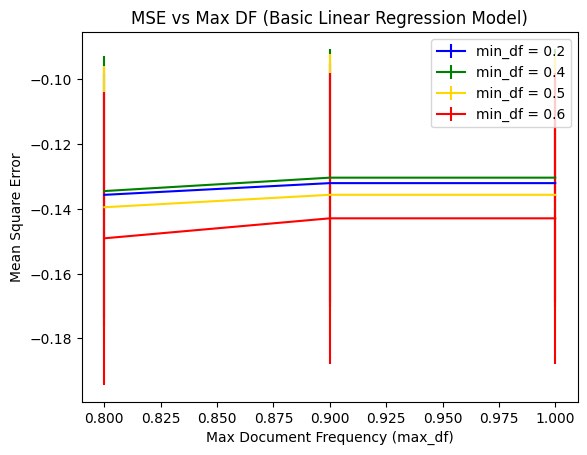

In [115]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

colors = ['blue', 'green', 'gold', 'red', 'pink']

# df_min - exclude words which appear in too few documents
min_df_range = [0.2, 0.4, 0.5, 0.6]
# df_max - exclude words which appear in too many documents
max_df_range = [0.8, 0.9, 1.0]

for min_df_index, min_df in enumerate(min_df_range):
    print(f'min_df = {min_df}')

    mean_score=[]
    std_score=[]

    for max_df in max_df_range:
        print(f' - max_df = {max_df}')

        vectorizer = TfidfVectorizer(stop_words='english', min_df=min_df, max_df=max_df) # 79,179 features for 6,078 listings
        X = vectorizer.fit_transform(stemmed_comments)

        model = LinearRegression()
        kf = KFold(n_splits=5)

        scores = cross_val_score(model, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
        mean_score.append(np.array(scores).mean())
        std_score.append(np.array(scores).std())

    plt.errorbar(max_df_range,mean_score,yerr=std_score,color=colors[min_df_index],label=f'min_df = {min_df}')

plt.title('MSE vs Max DF (Basic Linear Regression Model)')
plt.xlabel('Max Document Frequency (max_df)')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

In [113]:
# Set min_df and max_df to the values that gave the best results (lowest MSE)
MIN_DF = 0.4
MAX_DF = 0.9

vectorizer = TfidfVectorizer(stop_words='english', min_df=MIN_DF, max_df=MAX_DF) # 79,179 features for 6,078 listings
X = vectorizer.fit_transform(stemmed_comments)


In [114]:
print(X.shape)

(6078, 101)


C = 0.1
C = 0.15
C = 0.2
C = 0.25
C = 0.3


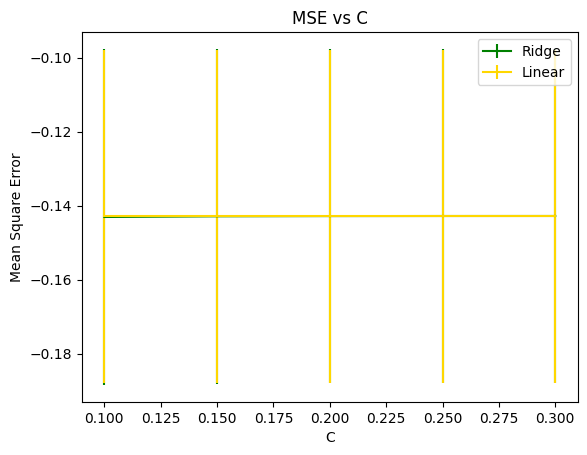

In [157]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

colors = ['blue', 'green', 'gold', 'red', 'pink']
c_range = [0.1, 0.15, 0.2, 0.25, 0.3]
# c_range = [2000, 4000, 6000, 8000, 10000]

m_linear = LinearRegression()

me_lasso = []
me_ridge = []
me_linear = []

se_lasso = []
se_ridge = []
se_linear = []

for c in c_range:
    print(f'C = {c}')
    
    m_lasso = Lasso(alpha=1/c)
    m_ridge = Ridge(alpha=1/c)

    kf = KFold(n_splits=5)

    errors_lasso = cross_val_score(m_lasso, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_ridge = cross_val_score(m_ridge, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_linear = cross_val_score(model, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')

    me_lasso.append(np.array(errors_lasso).mean())
    me_ridge.append(np.array(errors_ridge).mean())
    me_linear.append(np.array(errors_linear).mean())

    se_lasso.append(np.array(errors_lasso).std())
    se_ridge.append(np.array(errors_ridge).std())
    se_linear.append(np.array(errors_linear).std())

# plt.errorbar(c_range,me_lasso,yerr=se_lasso,color=colors[0],label=f'Lasso')
plt.errorbar(c_range,me_ridge,yerr=se_ridge,color=colors[1],label=f'Ridge')
plt.errorbar(c_range,me_linear,yerr=se_linear,color=colors[2],label=f'Linear')

plt.title('MSE vs C')
plt.xlabel('C')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

Standard Linear Regression (no regularization) works best. (Don't even really need to include this plot, since don't need cross-validation to select any C with no penalty)

In [139]:
def gaussian_kernel100(distances):
    weights = np.exp(-100*(distances**2))
    return weights/np.sum(weights)

def gaussian_kernel1000(distances):
    weights = np.exp(-1000*(distances**2))
    return weights/np.sum(weights)

def gaussian_kernel5000(distances):
    weights = np.exp(-5000*(distances**2))
    return weights/np.sum(weights)

k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10


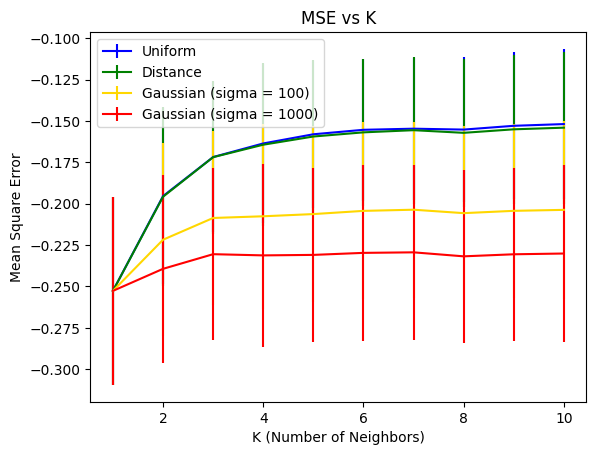

In [141]:
# CROSS-VALIDATION TO GET K FOR KNN MODEL

from sklearn.neighbors import KNeighborsRegressor

k_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Want a model with uniform weights, a model with distance weights, and a model for each of the three kernels
# And perform cross-validation on each of these models to get the best k

me_unif = []
me_dist = []
me_gaus100 = []
me_gaus1000 = []
# me_gaus5000 = []

se_unif = []
se_dist = []
se_gaus100 = []
se_gaus1000 = []
# se_gaus5000 = []

for k in k_range:
    print(f'k = {k}')
    
    # Model with uniform weights, a model with distance weights, and a model for each of the three kernels
    m_unif = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    m_dist = KNeighborsRegressor(n_neighbors=k, weights='distance')
    m_gaus100 = KNeighborsRegressor(n_neighbors=k, weights=gaussian_kernel100)
    m_gaus1000 = KNeighborsRegressor(n_neighbors=k, weights=gaussian_kernel1000)
    # m_gaus5000 = KNeighborsRegressor(n_neighbors=k, weights=gaussian_kernel5000)

    kf = KFold(n_splits=5)

    errors_unif = cross_val_score(m_unif, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_dist = cross_val_score(m_dist, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_gaus100 = cross_val_score(m_gaus100, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    errors_gaus1000 = cross_val_score(m_gaus1000, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')
    # errors_gaus5000 = cross_val_score(m_gaus5000, X, Y_rating, cv=kf, scoring='neg_mean_squared_error')

    me_unif.append(np.array(errors_unif).mean())
    me_dist.append(np.array(errors_dist).mean())
    me_gaus100.append(np.array(errors_gaus100).mean())
    me_gaus1000.append(np.array(errors_gaus1000).mean())
    # me_gaus5000.append(np.array(errors_gaus5000).mean())

    se_unif.append(np.array(errors_unif).std())
    se_dist.append(np.array(errors_dist).std())
    se_gaus100.append(np.array(errors_gaus100).std())
    se_gaus1000.append(np.array(errors_gaus1000).std())
    # se_gaus5000.append(np.array(errors_gaus5000).std())

plt.errorbar(k_range,me_unif,yerr=se_unif,color=colors[0],label=f'Uniform')
plt.errorbar(k_range,me_dist,yerr=se_dist,color=colors[1],label=f'Distance')
plt.errorbar(k_range,me_gaus100,yerr=se_gaus100,color=colors[2],label=f'Gaussian (sigma = 100)')
plt.errorbar(k_range,me_gaus1000,yerr=se_gaus1000,color=colors[3],label=f'Gaussian (sigma = 1000)')
# plt.errorbar(k_range,me_gaus5000,yerr=se_gaus5000,color=colors[4],label=f'Gaussian (sigma = 5000)')

plt.title('MSE vs K')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()


k = 6 neighbours w/ uniform weighting seems best

In [173]:
print(X[0])

  (0, 14)	0.06142421025102774
  (0, 6)	0.06831220557453328
  (0, 26)	0.06530440040750915
  (0, 0)	0.14158323005274073
  (0, 9)	0.1755342826810126
  (0, 7)	0.0963957522795151
  (0, 17)	0.19972038496654274
  (0, 16)	0.06938175563667849
  (0, 13)	0.23814942468919867
  (0, 8)	0.08481125490189349
  (0, 18)	0.13811275176438467
  (0, 22)	0.10053462460183046
  (0, 23)	0.0966463873583065
  (0, 4)	0.020715871731662838
  (0, 12)	0.07006233591516377
  (0, 15)	0.13558551169626268
  (0, 5)	0.2594678938936784
  (0, 2)	0.05198102592794461
  (0, 19)	0.15793580800753423
  (0, 10)	0.23798401519791101
  (0, 11)	0.1713783120193516
  (0, 1)	0.10906540106976151
  (0, 3)	0.1360730498157233
  (0, 25)	0.49171972300621425
  (0, 20)	0.188708420468916
  (0, 24)	0.35233609865276494
  (0, 21)	0.3786343949273005


MSE for Linear Regression: 0.12419831253896425
MSE for KNN: 0.1322929299159357
MSE for Mean: 0.1621077187664973
MSE for Constant: 0.6310181743421053


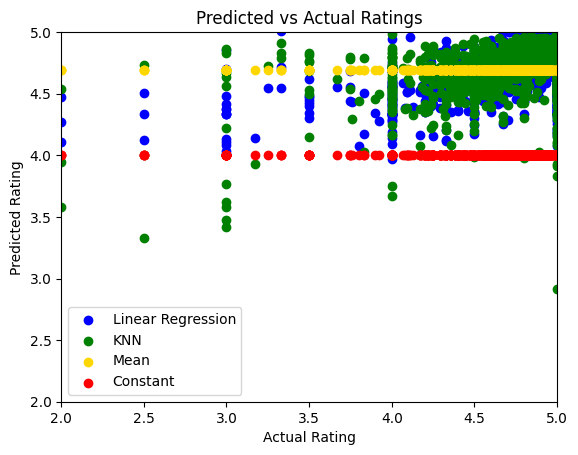

In [174]:
# COMPARE PERFORMANCE OF LINEAR AND KNN MODELS, ALONG WITH BASELINE PREDICTORS

# First get training and test data indices
from sklearn.model_selection import train_test_split
indices = np.arange(X.shape[0])
train, test = train_test_split(indices, test_size=0.2, random_state=0)


from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import roc_curve, auc

# Linear Regression
m_linear = LinearRegression()
m_linear.fit(X.toarray()[train], Y_rating[train])

# KNN
m_knn = KNeighborsRegressor(n_neighbors=6, weights='uniform')
m_knn.fit(X.toarray()[train], Y_rating[train])

# Baseline predictors (mean value and constant 4)
m_mean = DummyRegressor(strategy='mean')
m_mean.fit(X.toarray()[train], Y_rating[train])
m_const = DummyRegressor(strategy='constant', constant=4)
m_const.fit(X.toarray()[train], Y_rating[train])

# Get predictions for all models
pred_linear = m_linear.predict(X.toarray()[test])
pred_knn = m_knn.predict(X.toarray()[test])
pred_mean = m_mean.predict(X.toarray()[test])
pred_const = m_const.predict(X.toarray()[test])

# Calculate MSE for all models
from sklearn.metrics import mean_squared_error
mse_linear = mean_squared_error(Y_rating[test], pred_linear)
mse_knn = mean_squared_error(Y_rating[test], pred_knn)
mse_mean = mean_squared_error(Y_rating[test], pred_mean)
mse_const = mean_squared_error(Y_rating[test], pred_const)

print(f'MSE for Linear Regression: {mse_linear}')
print(f'MSE for KNN: {mse_knn}')
print(f'MSE for Mean: {mse_mean}')
print(f'MSE for Constant: {mse_const}')

# Visualise performance of all models
plt.scatter(Y_rating[test], pred_linear, color=colors[0], label='Linear Regression')
plt.scatter(Y_rating[test], pred_knn, color=colors[1], label='KNN')
plt.scatter(Y_rating[test], pred_mean, color=colors[2], label='Mean')
plt.scatter(Y_rating[test], pred_const, color=colors[3], label='Constant')

plt.title('Predicted vs Actual Ratings')
plt.xlabel('Actual Rating')
plt.xlim(2,5)
plt.ylabel('Predicted Rating')
plt.ylim(2,5)
plt.legend()
plt.show()



Not good :\

In [ ]:
# REFERENCE WORKFLOW ONLY

# Split data into training and test sets
# [Maybe use k-fold to do all of this in a loop?]

# 1) Train model for each target column
# Model 1: review_scores_rating
m_rating.fit(vectors[train], listings_targets[train][review_scores_rating_column])
# Model 2: review_scores_accuracy
m_acc.fit(vectors[train], listings_targets[train][review_scores_accuracy_column])
# Model 3: review_scores_cleanliness
m_clean.fit(vectors[train], listings_targets[train][review_scores_cleanliness_column])
# Model 4: review_scores_checkin
m_checkin.fit(vectors[train], listings_targets[train][review_scores_checkin_column])
# Model 5: review_scores_communication
m_comm.fit(vectors[train], listings_targets[train][review_scores_communication_column])
# Model 6: review_scores_location
m_loc.fit(vectors[train], listings_targets[train][review_scores_location_column])
# Model 7: review_scores_value
m_value.fit(vectors[train], listings_targets[train][review_scores_value_column])

# 2) Predict for each target column
# Model 1: review_scores_rating
m_rating.predict(vectors[test])
# Model 2: review_scores_accuracy
m_acc.predict(vectors[test])
# Model 3: review_scores_cleanliness
m_clean.predict(vectors[test])
# Model 4: review_scores_checkin
m_checkin.predict(vectors[test])
# Model 5: review_scores_communication
m_comm.predict(vectors[test])
# Model 6: review_scores_location
m_loc.predict(vectors[test])
# Model 7: review_scores_value
m_value.predict(vectors[test])

# 3) Evaluate each model
# NOTE: [I don't know how to do this yet. Copilot wrote this for me. Might be where we do k-fold cross validation.]
# Model 1: review_scores_rating
m_rating.score(vectors[test], listings_targets[test][review_scores_rating_column])
# Model 2: review_scores_accuracy
m_acc.score(vectors[test], listings_targets[test][review_scores_accuracy_column])
# Model 3: review_scores_cleanliness
m_clean.score(vectors[test], listings_targets[test][review_scores_cleanliness_column])
# Model 4: review_scores_checkin
m_checkin.score(vectors[test], listings_targets[test][review_scores_checkin_column])
# Model 5: review_scores_communication
m_comm.score(vectors[test], listings_targets[test][review_scores_communication_column])
# Model 6: review_scores_location
m_loc.score(vectors[test], listings_targets[test][review_scores_location_column])
# Model 7: review_scores_value
m_value.score(vectors[test], listings_targets[test][review_scores_value_column])
